Radiation Pressure simulation with 
SI units,
1 Sun-like star,
belts belts of debris
Ncolpbelt number of collisions per belt
Ncol collisions total, 
Ndust massless particles per collision and 
Npl planets

This copy has better indexing than the first

no p-r drag
Noutput outputs from sim,
randomized or linearly distributed orbital elements per particle,
grain size linearly or randomly distributed from 1-10 microns,
xyz positions of each particle stored in xyz array,

plotted in 9 time steps from above and 2 time steps edge-on,
colourmap maps size of grain (not sure how it's associated though),

particles with e>0.9 (unbound or very long period orbit) are removed from sim,

semi-major axis and beta plotted against grain size,

May 16th: first thing to do tomorrow is figure out how to evenly space the collisions around the orbit

May 17th: add variable for rows and cols

MAy 18th: Copy2: going to make an addcol() function that will take in which belt the new collision happens in, randomizes the orbital elements a bit, and produces a new set of dust particles, added on to the ps array

In [1]:
import rebound
import reboundx
import numpy as np
import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D
import random as rand
import math
import matplotlib.cm as cm
import seaborn as sns
from matplotlib.colors import ListedColormap
np.random.seed(sum(map(ord, "aesthetics")))
np.random.seed(sum(map(ord, "palettes")))


In [13]:
#set up sim, put units in SI, 
#set number of gravitationally interactive bodies
#add sun, pointer array to particles
sim = rebound.Simulation()
sim.G = 6.674e-11 # SI
sim.dt = 1e5 #seconds, 1/20th of a year
sim.N_active = 1 
sim.add(m=1.99e30, hash="Sun") #mass in kg
ps = sim.particles

#set up radiation force
rebx = reboundx.Extras(sim)
rf = rebx.add("radiation_forces") #extra force added
rf.params["c"] = 3.e8 #speed of light in m

### initialize random seed, planets, collisions massless particles
### each collision gets same number of particles
### linear distribution of grain sizes for each collision
### lists of orbital elements for different collision locations

seed = 3
rand.seed(seed)
AU = 1.5e11 # in m

#add the random particles
belts = 1
Ncolpbelt = 10 #number of collisions per belt
Ncol = Ncolpbelt*belts
totaldust = 100
Ndust = int(totaldust/Ncol) #number of grains per collision

def beltradius(belt):
    a = AU*(belt+1)
    return a;

def addcol(belt):
    #for distributing grain size and calculating beta
    grain_rad_min = 1.e-6
    grain_rad_width = 1.e-5
    scale = np.linspace(0,0.99,Ndust) #linearly scaled grain size
    density = 1000. #kg/m^3 = 1g/cc
    Q_pr = 1.
    luminosity = 3.85e26 #Watts
    
    #randomize orbital element values and betas for each particle
    a = beltradius(belt)
    awidth = 0.1*AU*rand.random()
    e=np.random.triangular(0,0.01,0.2)
    incmax = np.arcsin(0.01*belt)
    inc = incmax*rand.random()
    Omega = 2*np.pi*rand.random()
    pomega = 2*np.pi*rand.random()
    f = 2*np.pi*rand.random()
    for i in range(0,Ndust): 
        grain_radius = grain_rad_min + grain_rad_width*scale[i] ##TODO the grain radius and grainsize are defined differently and that cant be good
        sim.add(a=a+awidth, e=e, inc=inc, Omega=Omega, pomega=pomega, f=f, hash=i+sim.N+1)
        ps[-1].params["grainsize"] = np.random.triangular(1.e-6, 1.1e-6, 1.e-5)
        ps[-1].params["beta"] = rebx.rad_calc_beta(sim.G, rf.params["c"], \
                        ps[0].m, luminosity, grain_radius, density, Q_pr)

#add all the initial collisions
for j in range(belts):
    for i in range(Ncolpbelt):
        addcol(j+1)

In [14]:
#integrate over sim, recording particle and planet locations
year = 365*24*3600 # seconds
Noutput = 500
numyears = 100
times = np.linspace(0, numyears*year, Noutput)
xyz = np.zeros((Noutput, belts, Ncolpbelt, Ndust, 3))
for i, time in enumerate(times):
    sim.integrate(time)
    for j in range(belts):
        for k in range(Ncolpbelt):
            #Ncolpbelt = Ncolpbelt+1
            
            for l, p in enumerate(ps[Ndust*(k+j*Ncolpbelt)+1:Ndust*(k+1+j*Ncolpbelt)+1]):
                xyz[i][j][k][l] = [p.x/AU, p.y/AU, p.z/AU]

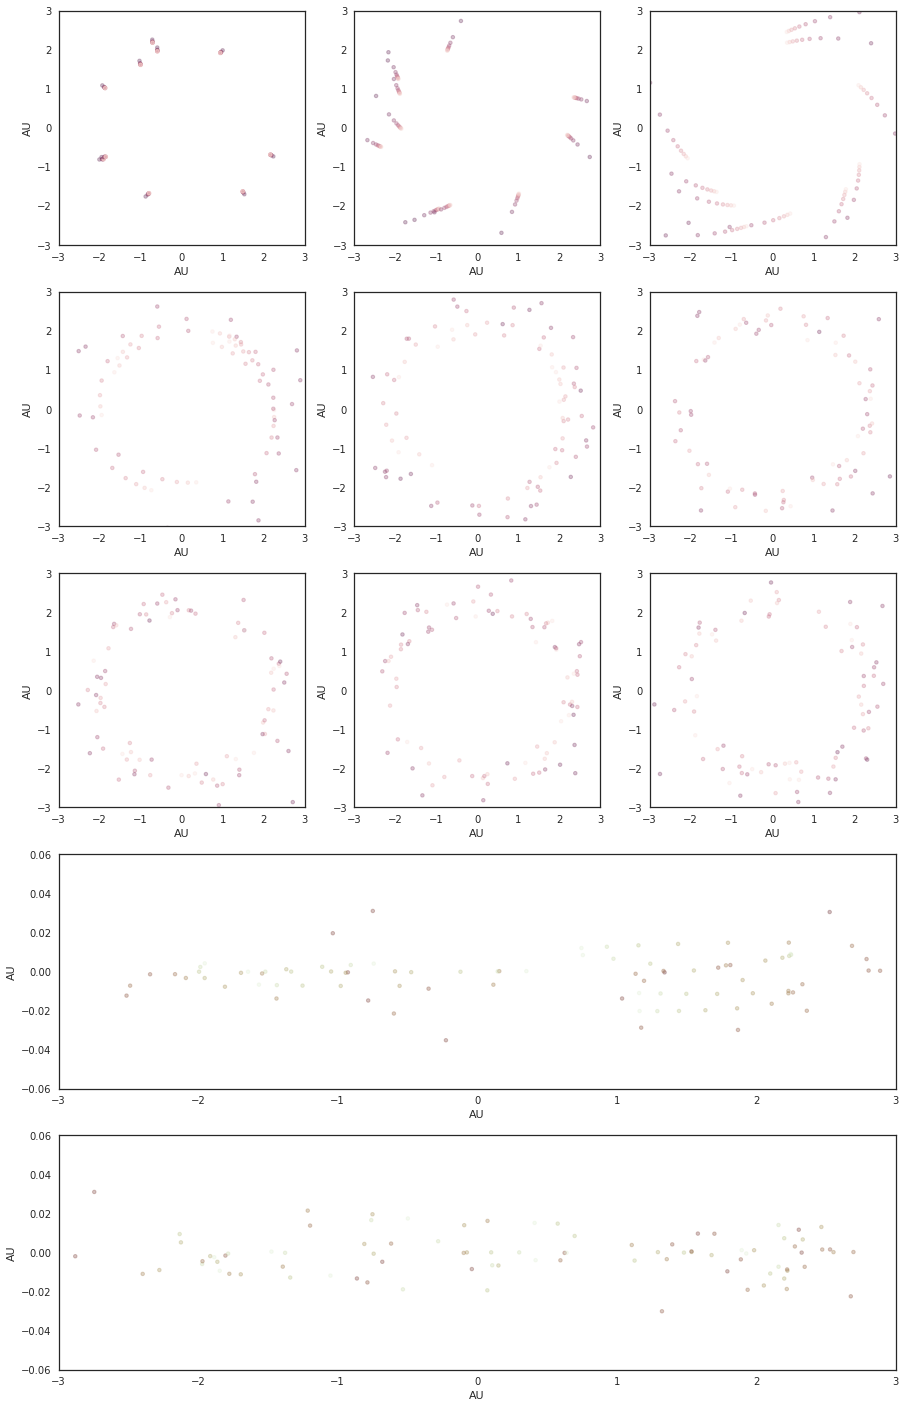

In [15]:
sns.set()
sns.set_style("white")

nplot = 9
row = int(math.ceil(nplot/3)+2)
col = 3
res = 1
size = res*1


fig = plt.figure(figsize=(col*5*res,row*5*res))
lim = 1.5*beltradius(belts)/AU #in AU
alpha = 0.3

#create colourmap array
start = np.arange(0,3,3/belts)
helmap = [sns.cubehelix_palette(8, start=start[i], rot=0.35, light=0.95, dark=0.5, hue=1,\
                                gamma=2, as_cmap=True, reverse=True) for i in range(belts)]
#, c=c, cmap=helmap[int(i/Ncolpbelt)],linewidth=size,alpha=alpha
#size=[]
#for i in range(1,Ndust):
#    size.append((ps[i].params["grainsize"])*1e6*res) #scaled point sizes
### , c=c, cmap=cmap[17+i], alpha=alpha   ###
c = np.arange(Ndust)

def plot_face(t, xyz, lim=lim):
    ax.set_xlabel("AU")
    ax.set_ylabel("AU")
    ax.set_xlim([-lim,lim])
    ax.set_ylim([-lim,lim])
    for h in range(belts):
        cmap = sns.cubehelix_palette(8, start=start[h], rot=0.35, light=0.95, dark=0.5, hue=1,\
                                gamma=2, as_cmap=True, reverse=True)
        for i in range(Ncolpbelt):
            ax.scatter(xyz[t,h,i,:,0],xyz[t,h,i,:,1], marker=".", \
                       c=c, cmap=cmap,linewidth=size,alpha=alpha);

def plot_edge(t, xyz, lim=lim):
    ax.set_xlabel("AU")
    ax.set_ylabel("AU")
    ax.set_xlim([-lim,lim])
    ax.set_ylim([-lim/50,lim/50])
    for h in range(belts):
        cmap = sns.cubehelix_palette(8, start=start[h], rot=0.6, light=0.95, dark=0.5, hue=1,\
                                gamma=2, as_cmap=True, reverse=True)
        for i in range(Ncolpbelt):
            ax.scatter(xyz[t,h,i,:,0],xyz[t,h,i,:,2], marker=".", \
                       c=c, cmap=cmap,linewidth=size,alpha=alpha);

for i in range(1,1+nplot):
    ax = plt.subplot(row, col, i)
    plot_face(int(Noutput**(i*0.11*9/nplot)), xyz)
#for i in range(1,2):
    

ax = plt.subplot(row, 1, row-1)
plot_edge(int(Noutput**(4*0.11)), xyz)
ax = plt.subplot(row, 1, row)
plot_edge(int(Noutput**(9*0.11)), xyz)


In [ ]:
for i in range(1,Ndust+1)
xx,yy=[ps[i].x for i in range(Ndust)],[ps[i].y for i in range(Ndust)]
fig = plt.figure(figsize=(5,5))
plt.hist2d(xx,yy, bins=(100,100),cmin=1, cmap="magma_r")
plt.show()

In [ ]:
fig=plt.figure(figsize=(5,5))
x=np.linspace(-5,5,100)
y=np.linspace(-5,5,100)
X,Y = np.meshgrid(x,y)
h = plt.hist2d(xx,yy, bins=(100,100))
print(h[0])
plt.contourf(X,Y, h[0], linewidths=10, cmap="magma_r")

In [18]:


max_a = (((year*numyears)**2)*sim.G*ps[0].m/(4*(np.pi**2)))**(1/3)

print(max_a)

print("Number of particles before cut = {0}".format(sim.N-1))
for i in reversed(range(1,Ndust*Ncol+1)):
    if ps[i].e > 0.5:
        sim.remove(i)
print("Number of particles after cut = {0}".format(sim.N-1))

#print("Number of particles before add = {0}".format(sim.N-1))
#addcol(1)
#print("Number of particles after add = {0}".format(sim.N-1))

#Ndust=int((sim.N-1)/Ncol)

#fig1 = rebound.OrbitPlot(sim, trails=True, unitlabel="[AU]")

3222287243158.291
Number of particles before cut = 100
Number of particles after cut = 85


NameError: name 'xx' is not defined

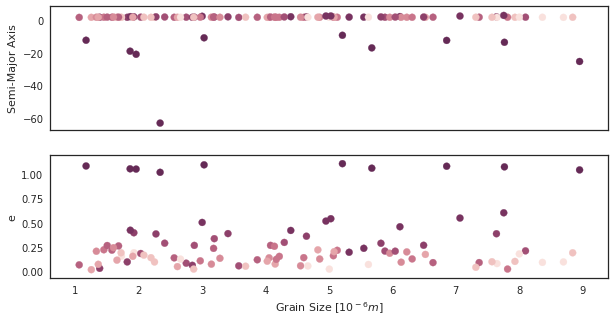

In [17]:
d = 1  # reduction factor for looking at interesting area of plot
cc = np.arange(0,Ndust)

aaxis=np.zeros((Ncol, Ndust)) 
ee=np.zeros((Ncol, Ndust))
beta=np.zeros((Ncol, Ndust))
size=np.zeros((Ncol, Ndust))

for j in range(Ncol):
    
    for i in range(0, Ndust):
        k = Ndust*j+i+1
        aaxis[j][i] = ps[k].a/AU
        ee[j][i] = ps[k].e
        beta[j][i] = ps[k].params["beta"]
        size[j][i] = ps[k].params["grainsize"]*1e6

fig2 = plt.figure(figsize=(10,5))

ax1 = plt.subplot(211)
ax1.set_ylabel('Semi-Major Axis')
plt.setp(ax1.get_xticklabels(), visible=False)
ax2 = plt.subplot(212, sharex=ax1)
ax2.set_xlabel('Grain Size [10$^-$$^6m$]')
ax2.set_ylabel('e')
for i in range(Ncol):
    ax1.scatter(size[i], aaxis[i], c=cc, cmap=helmap[int(i/Ncolpbelt)])
    ax2.scatter(size[i], ee[i], c=cc, cmap=helmap[int(i/Ncolpbelt)])